In [1]:
from collections import defaultdict
import random
import operator
import matplotlib.pyplot as plt

class Sample:
    def __init__(self):
        self.S = set()
        self.Neighbor = {}

    def addEdge(self, u, v):
        self.S.add((u,v))
            
        if u in self.Neighbor.keys():
            self.Neighbor[u].add(v)
        else:
            self.Neighbor[u] = set([v])
        # If point u is already in the sample, we put point v in the set of point u's neighbor; 
        # else we keep the previours neighbor set [v]
        if v in self.Neighbor.keys():
            self.Neighbor[v].add(u)
        else:
            self.Neighbor[v] = set([u])
        # For point v, we do the same thing.
        
    def removeEdge(self, u, v):
        self.S.remove((u,v))
            
        self.Neighbor[u].remove(v)
        self.Neighbor[v].remove(u)
            
        if(len(self.Neighbor[u]) == 0):
            del self.Neighbor[u]
        if(len(self.Neighbor[v]) == 0):
            del self.Neighbor[v]
        # After we successfully selected one edge (u,v) which is needed to remove from the sample, 
        # we remove point v from the neighbor set of u and remove point u from the neighbor set of v.
        # If point u has no neighbor after remove, we delete the neighbor set of u.
        
class Triest:
    def __init__(self,M):
        self.M = M #The size of the sample.
        self.t = 0.0 # Time step, start from 0.
        self.tau = defaultdict(lambda:0) # Local triangle, triangle from one point.
        self.TAU = 0  # Total triangles in the sample, start from 0.
        self.samp=Sample()
        self.Tcount=0 
        # Global triangle, need to be estimate by 
        # global triangles = 
        # the total triangles in sample / the probability that a triangle (a, b, c) of the global triangles is in the sample
        
    def sampleEdge(self):
        if(self.t <= self.M):
            return True
        # If t<= M, continue to add edge in the sample.
        else:
            if(random.random() < self.M/self.t):
                toremove = random.choice(tuple(self.samp.S))
                u = toremove[0]
                v = toremove[1]
                self.samp.removeEdge(u,v)
                self.updateCounters("-",u,v)                
                return True
        # If reture "True", we do the opeartion add/ remove.
        # If t> M, do the flip bias. 
        # The expectation of "random"=0.5, as the increase of t, we will have lower possibility to remove edge from the sample.
        # e.g., we have t=1000, M=100, we will expect to change 1 edge in the sample after the t increase by 10.
        # So we can have a better representative sample of the whole dataset based on the current time.
        return False
        # If return "False", we do nothing.
        
    def updateCounters(self,operation,u,v):
        if(u in self.samp.Neighbor.keys() and v in self.samp.Neighbor.keys()):
            Nu = self.samp.Neighbor[u]
            Nv = self.samp.Neighbor[v]
        # If a new edge (u,v) is already in the sample and have neighbor, we make a intersection for
        # point u's neighbor and v's neighbor.
            Nuv = Nu & Nv
        # If this intersection is not 0, for every common neighbor point,
        # we need to add/remove a triangle from the local triangle of u, v, c, and add/remove a triangle from the sample.
        # add/ remove depends on the result of "sampleEdge". 
            if(len(Nuv) > 0):
                for c in Nuv:
                    if operation=='+':
                        self.TAU+=1
                        self.tau[c]+=1
                        self.tau[u]+=1
                        self.tau[v]+=1

                    if operation=='-':
                        self.TAU-=1
                        self.tau[c]-=1
                        self.tau[u]-=1
                        self.tau[v]-=1
                        if(self.tau[c] == 0):
                            del self.tau[c]
                        if(self.tau[u] == 0):
                            del self.tau[u]
                        if(self.tau[v] == 0):
                            del self.tau[v]
                            
            self.epsilon = max(1, (self.t*(self.t-1)*(self.t-2))/(self.M*(self.M-1)*(self.M-2)))
            self.Tcount = int(self.epsilon * self.TAU)                
                
    def launchTriest(self,filepath):
        file = open(filepath,'r')
        for line in file:
            input = line.split()
            u = int(min(input))
            v = int(max(input))
            
            if((u,v) in self.samp.S or u == v):
                continue
            # If u, v is already in the sample, or u=v, we skip this point and go to next point, t will not increase. 
            self.t += 1
            # t <= the total line in the dataset.
            if(self.sampleEdge()):
                self.samp.addEdge(u,v)
                self.updateCounters("+",u,v)
        file.close() 
        print('global:',self.Tcount)
    
class Triest_IMP:
    def __init__(self,M):
        self.M = M
        self.t = 0
        self.tau = defaultdict(lambda:0)
        self.TAU = 0  
        self.samp=Sample()

    def sampleEdge(self):
        if(self.t <= self.M):
            return True
        else:
            if(random.random() < self.M/self.t):
                toremove = random.choice(tuple(self.samp.S))
                u = toremove[0]
                v = toremove[1]
                self.samp.removeEdge(u,v)              
                return True
        return False
    
    def updateCounters(self,u,v):
        if(u in self.samp.Neighbor.keys() and v in self.samp.Neighbor.keys()):
            Nu = self.samp.Neighbor[u]
            Nv = self.samp.Neighbor[v]

            Nuv = Nu & Nv
            
            epsilon = max(1, int((self.t-1)*(self.t-2)/(self.M*(self.M-1))) )
            
            # In the improve algorithm, we did not estimate the global triangle by using "triangles in the sample / possibility"
            # The epsilon is the increment of the global triangles.
            # We weight the increment and add it to the global triangle, whether the add/remove an edge from the sample.

            if(len(Nuv) > 0):
                for c in Nuv:
                    self.tau[c] += epsilon
                    self.tau[u] += epsilon
                    self.tau[v] += epsilon
                    self.TAU += epsilon                    
            # For each common point c, we need to increase the local triangle and the global triangle.
            
    def launchTriest(self,filepath):
        file = open(filepath,'r')
        for line in file:
            input = line.split()
            u = int(min(input))
            v = int(max(input))
            
            if((u,v) in self.samp.S or u == v):
                continue
            
            self.t += 1           
            self.updateCounters(u,v)
            # UpdateCounters will happen every time, and before the operation(add/ remove edge) on the sample.
            if(self.sampleEdge()):
                self.samp.addEdge(u,v)
        file.close() 
        print('global:',self.TAU)
    

Triest:
Ms: 500
global: 2274
Ms: 1000
global: 2948
Ms: 1500
global: 2976
Ms: 2000
global: 2945
Ms: 2500
global: 3004
Ms: 3000
global: 3004
Triest_IMP:
Ms: 500
global: 2469
Ms: 1000
global: 2792
Ms: 1500
global: 2746
Ms: 2000
global: 2929
Ms: 2500
global: 3004
Ms: 3000
global: 3004


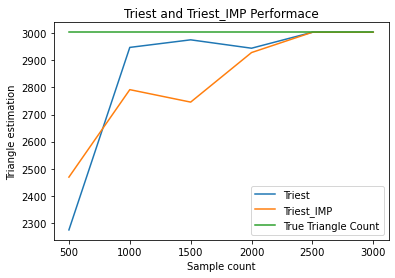

In [2]:
# Calculate the golbal triangles for different sample size.
Ms=[500,1000,1500,2000,2500,3000]
true=[3004 for i in range(len(Ms))]
print('Triest:')
x1=[]
for i in Ms:
    print('Ms:',i)
    triest = Triest(i)
    triest.launchTriest('web-polblogs.mtx')
    x1.append(triest.Tcount)
print('Triest_IMP:')    

x2=[]
for i in Ms:
    print('Ms:',i)
    triestImpr = Triest_IMP(i)
    triestImpr.launchTriest('web-polblogs.mtx')
    x2.append(triestImpr.TAU)

plt.plot(Ms,x1,label='Triest')
plt.plot(Ms,x2,label='Triest_IMP')
plt.plot(Ms,true,label='True Triangle Count')

plt.ylabel('Triangle estimation')
plt.xlabel('Sample count')
plt.title('Triest and Triest_IMP Performace')
plt.legend()
plt.show()
    

In [ ]:
# Calculate the golbal triangles for different sample size.
Ms=[500,1000,2000,4000,10000,50000]

true=[3004 for i in range(len(Ms))]
print('Triest:')
x1=[]
for i in Ms:
    print('Ms:',i)
    triestImpr = Triest(i)
    triestImpr.launchTriest('web-Berkstan.txt')
    x1.append(triestImpr.Tcount)
print('Triest_IMP:')    

x2=[]
for i in Ms:
    print('Ms:',i)
    triestImpr = Triest_IMP(i)
    triestImpr.launchTriest('web-Berkstan.txt')
    x2.append(triestImpr.TAU)

plt.plot(Ms,x1,label='Triest')
plt.plot(Ms,x2,label='Triest_IMP')
plt.plot(Ms,true,label='True Triangle Count')

plt.ylabel('Triangle estimation')
plt.xlabel('Sample count')
plt.title('Triest and Triest_IMP Performace')
plt.legend()
plt.show()
    

Triest:
Ms: 500
global: 0
Ms: 1000
global: 0
Ms: 2000
global: 0
Ms: 4000
global: 0
Ms: 10000
global: 438195070
Ms: 50000


In [ ]:
true=[64690980 for i in range(len(Ms))]
plt.plot(Ms,x1,label='Triest')
plt.plot(Ms,x2,label='Triest_IMP')
plt.plot(Ms,true,label='True Triangle Count')

plt.ylabel('Triangle estimation')
plt.xlabel('Sample count')
plt.title('Triest and Triest_IMP Performace')
plt.legend()
plt.show()